In [161]:
import numpy as np
import datetime as dt
import pandas as pd
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, mean_absolute_percentage_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import calendar
import yfinance as yf
from multiprocessing import Pool, cpu_count
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import openai
from openai import OpenAI
from sklearn.metrics import accuracy_score, classification_report
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iyenleung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [162]:
sia = SentimentIntensityAnalyzer()
# classification of GPT, SIA, TextBlob
def analyze_sentiment_sia(text):
    if isinstance(text, float):
        text = str(text)
    score = sia.polarity_scores(text)['compound']
    return 2 if score > 0.05 else 1 if score < -0.05 else 0

def analyze_sentiment_textblob(text):
    if isinstance(text, float):
        text = str(text)
    polarity = TextBlob(text).sentiment.polarity
    return 2 if polarity > 0.05 else 1 if polarity < 0.05 else 0

def analyze_sentiment_gpt(text):
    if isinstance(text, float):
        text = str(text)
    score = get_gpt35_sentiment_score(text)
    score = float(score)
    return 2 if score > 0.05 else 1 if score < -0.05 else 0

# clean tweets by removing unnecessary links, tags, punctuations..
def clean_tweet(text):
    # Remove retweet indicator
    text = re.sub(r'\bRT\b', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove links
    text = re.sub(r'http\S+', '', text)
    # Remove stock symbols like $AAPL but not monetary values
    text = re.sub(r'\$(?!AMZN)\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters (except letters, numbers, and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# clean english stop words
def clean_stop_words(text):
    words = text.split()
    stop_words = [word for word in words if word not in stopwords.words("english")]
    return ' '.join(stop_words)

# remove duplicated phrases caused by retweets
def remove_duplicated_phrases(text):
    # Split text into phrases based on '.'
    phrases = text.split('.')
    # Use a set to store unique phrases
    unique_phrases = set()
    # List to hold the cleaned phrases
    cleaned_phrases = []
    for phrase in phrases:
        phrase = phrase.strip()
        if phrase and phrase not in unique_phrases:
            cleaned_phrases.append(phrase)
            unique_phrases.add(phrase)
    # Reconstruct the text from unique phrases
    cleaned_text = ' . '.join(cleaned_phrases)
    return cleaned_text


The followng cell shows how removing stop words works.

In [5]:
# example for data cleaning
abc = "this is not good at all"
print("original sentence:",abc)
print("after removing stop words:",clean_stop_words(abc))
print(filter_sentiment_words(abc))

original sentence: this is not good at all
after removing stop words: good
good


Here is a quick look on the original dataset taken from Kaggle, containing 3.7 million financial tweets, this dataset will be cleaned in the following.

In [157]:
original_tweets = pd.read_csv('Tweet.csv')

In [158]:
original_tweets.head(10)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
5,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
6,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
7,550443857142611968,Cprediction,1420071016,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
8,550443857595600896,iknowfirst_br,1420071017,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
9,550443857692078081,Gold_prediction,1420071017,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


Using datasets from kaggle and stock prices information from Yahoo Finance, do data cleaning and preprocessing and combine them and save them in order for later use.

In [33]:
# pre process data from twitter
def data_preparation():
    # set company, e.g 'AAPL', 'AMZN', 'GOOG', 'TSLA'
    company = 'AMZN'
    # set period
    start = dt.datetime(2015, 1, 1)
    end = dt.datetime(2020, 1, 1)
    start_date = '2015-01-01'
    end_date = '2020-01-01'
    # load data from yahoo finance
    stock_data = yf.download(company, start, end)
    # load data from csv provided by Kaggle
    company_tweets = pd.read_csv('Company_Tweet.csv')
    twitter_data = pd.read_csv('Tweet.csv')
    twitter_data = twitter_data.merge(company_tweets, how='left', on='tweet_id')
    twitter_data['post_date'] = pd.to_datetime(twitter_data['post_date'], unit='s').dt.strftime('%Y-%m-%d')
    # filter twitter data by company and time period
    twitter_data = twitter_data[(twitter_data.ticker_symbol == company) & (twitter_data['post_date'] >= start_date) &
                                (twitter_data['post_date'] <= end_date)]

    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.strftime('%Y-%m-%d')
    
    filter_data = twitter_data.copy()

    filter_data = filter_data.dropna(subset=['comment_num', 'retweet_num', 'like_num'])
    
    # Calculate total engagement
    filter_data['total_engagement'] = filter_data['comment_num'] + filter_data['retweet_num'] + filter_data['like_num']

    # select top 10 tweets of everyday
    filter_data = filter_data.sort_values(['post_date', 'total_engagement'], ascending=[True, False])
    top_tweets = filter_data.groupby('post_date').head(10).copy()
    
    # Clean the tweets
    top_tweets.loc[:, 'tweets'] = top_tweets['body'].apply(clean_tweet)
    top_tweets = top_tweets.drop(['body', 'comment_num', 'retweet_num', 'like_num', 'total_engagement'], axis=1)

    # Aggregate filtered tweets and stock prices by post_date
    aggregated_tweets = top_tweets.groupby('post_date')['tweets'].apply(lambda x: '. '.join(x)).reset_index(name='tweets')
    merged_data = pd.merge(stock_data, aggregated_tweets, left_on='Date', right_on='post_date', how='inner')
    merged_data.set_index('Date', inplace=True)
    merged_data.drop('post_date', axis=1, inplace=True)

    return merged_data

In [34]:
data = data_preparation()

[*********************100%***********************]  1 of 1 completed


In [36]:
# here is a sample cell of the dataset after cleaning the tweets. 
data.iloc[2,6]

'Amazon AMZN upped the ante in its battle with Netflix announcing 13 new original series . Amazons thirdparty sellers shipped 2 billion units in 2014 double the 2013 figure AMZN . A number of key leaders have become laggardsAMZN their place biotechs like and . My view on another year of disruption Video The outlook for Canadas 2015 retail sector AMZN . U guys want more bags I got plenty of them for you AMZN . Amazon Facebook and Google have quitely built up microprocessor teams . If you have to ask how much an LG ultraHD OLED TV costs you probably cant afford one AMZN . Popular opinion 18 mos ago AMZN is absolute Bear that crushes small Cos Unstoppable machineNow Rudderless Unfocused Vulnerable . 6 Top Internet and Digital Media Stocks to Buy for 2015 AMZN . I thought had the AMZN story market cornered Great read Bezoss Fire Phone Debacle'

In [37]:
# save the processed csv
path = '/Users/iyenleung/Desktop/data_amzn_top.csv'
data.to_csv(path, index='Date')

Showing the sample csv saved by data_preparation()

In [155]:
sample1 = pd.read_csv('data_amzn_top.csv')
sample2 = pd.read_csv('data_aapl_top.csv')
sample3 = pd.read_csv('data_goog_top.csv')

In [156]:
sample1.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,tweets
0,2015-01-02,15.6290,15.7375,15.3480,15.4260,15.4260,55664000,Analyst Report on Top Stock Market Options for...
1,2015-01-05,15.3505,15.4190,15.0425,15.1095,15.1095,55484000,Amazons thirdparty sellers shipped 2 billion u...
2,2015-01-06,15.1120,15.1500,14.6190,14.7645,14.7645,70380000,Amazon AMZN upped the ante in its battle with ...
3,2015-01-07,14.8750,15.0640,14.7665,14.9210,14.9210,52806000,Amazon unveils 13 new shows AMZN . LinkedIn sh...
4,2015-01-08,15.0160,15.1570,14.8055,15.0230,15.0230,61768000,7 Trends That Will Shape How You Shop This Yea...
5,2015-01-09,15.0740,15.1435,14.8340,14.8465,14.8465,51848000,Yo Chief what the heck are you talking about I...
6,2015-01-12,14.8780,14.9255,14.4640,14.5705,14.5705,68428000,Seeing a short setup in AMZN . Since Jan 2014A...
7,2015-01-13,14.8740,15.0750,14.6615,14.7370,14.7370,82728000,Roger McNamee Exec Chairman of on AMZN on . Wo...
8,2015-01-14,14.5965,14.7955,14.3250,14.6635,14.6635,110774000,Strong revenue growth and the prospect of impr...
9,2015-01-15,14.7000,14.8000,14.3410,14.3475,14.3475,88384000,AMZNs not quite as big or successful as it see...


--------------------------------------------------Testing Accurracy ------------------------------------------------------------------

In [165]:
# set the api key, please go to OpenAI's website and generate one, in order to run this method
openai.api_key = 'ThisIsASampleAPIKEY09431274-03428237'

def get_gpt35_sentiment_score(text):
    # command for GPT
    prompt = f"Please provide a sentiment score only with no other text\
    between -1 (very negative) and 1 (very positive) for the following text:\n\n{text}"
    chat_completion = openai.chat.completions.create(
    messages=[
        #set GPT's role
            {"role": "system", "content": "You are a sentiment analysis assistant."},
            {"role":"user",
            "content":prompt}
        ],
        # set model, e.g gpt-4, gpt-4o, gpt-3.5-turbo, etc
        model = "gpt-3.5-turbo"
    )
    sentiment_score = chat_completion.choices[0].message.content
    try:
        # return text message as float number
        return float(sentiment_score)
    except ValueError:
        # error handling if GPT is not providing a float number
        sentiment_score = re.findall("\d+\.\d+", sentiment_score)
        sentiment_score = [float(num) for num in sentiment_score]
        if len(sentiment_score) != 0:
            sentiment_score = sum(sentiment_score)/len(sentiment_score)
            return float(sentiment_score)
        else:
            return 0.0

In [166]:
get_gpt35_sentiment_score("Good read from Dec 27 by re AAPL Supports our buyback thesis|Despite lawsuit AAPL iOS 8 is far more storage efficient than Android Windows|Apples stock has fallen below Why investors say thats a bad sign AAPL|Weekend Review VIDEO AAPL|AAPL is down but only in paper terms Physical AAPL is unchanged and has moved into strong hands|Apple is down 735 over the last 5 trading days Its taking a big hit right now too AAPL|Apple nearing a major support level AAPL|Apple share close down for the fifth straight day losing 68 in that period worst 5day drop since Feb 2014 AAPL|Top searched stocks of 2014 via AAPL|My Weekend Review 1415 AAPL")

-0.25

In [334]:
TextBlob("it is not good, it is great!!!").sentiment.polarity

0.325

Show a classic example where the sentiment analysis models perform very differently

In [45]:
# read data downloaded from kaggle
test_data = pd.read_csv('test_accuracy.csv')

# Randomly select 1000 rows
accuracy_data = test_data.sample(n=1000, random_state=42)

# Display the first few rows of the dataset
print(accuracy_data.head())

        class_index                             review_title  \
23218             2                     This is a great book   
20731             1                     Huge Disappointment.   
39555             2  Wayne is tight but cant hang with Turk.   
147506            2                                Excellent   
314215            1                        Not about Anusara   

                                              review_text  
23218   I must preface this by saying that I am not re...  
20731   As a big time, long term Trevanian fan, I was ...  
39555   This album is hot as it wants to be. However C...  
147506  I read this book when I was in elementary scho...  
314215  Although this book is touted on several Anusar...  


Test the accuracy between 3 models -- GPT, SIA, TextBlob

In [47]:
accuracy_data['review_text'] = accuracy_data['review_text'].astype(str).fillna('')


# Apply sentiment analysis
accuracy_data['SIA_sentiment'] = accuracy_data['review_text'].apply(analyze_sentiment_sia)
accuracy_data['TextBlob_sentiment'] = accuracy_data['review_text'].apply(analyze_sentiment_textblob)
accuracy_data['GPT_sentiment'] = accuracy_data['review_text'].apply(analyze_sentiment_gpt)

In [50]:
# Calculate accuracy for SIA
sia_accuracy = accuracy_score(accuracy_data['class_index'], accuracy_data['SIA_sentiment'])
print(f"SIA Accuracy: {sia_accuracy}")
print("SIA Classification Report:")
print(classification_report(accuracy_data['class_index'], accuracy_data['SIA_sentiment'], zero_division=0))

# Calculate and print accuracy for TextBlob
textblob_accuracy = accuracy_score(accuracy_data['class_index'], accuracy_data['TextBlob_sentiment'])
print(f"TextBlob Accuracy: {textblob_accuracy}")
print("TextBlob Classification Report:")
print(classification_report(accuracy_data['class_index'], accuracy_data['TextBlob_sentiment'], zero_division=0))

# Calculate and print accuracy for GPT
gpt_accuracy = accuracy_score(accuracy_data['class_index'], accuracy_data['GPT_sentiment'])
print(f"GPT Accuracy: {gpt_accuracy}")
print("GPT Classification Report:")
print(classification_report(accuracy_data['class_index'], accuracy_data['GPT_sentiment'], zero_division=0))

SIA Accuracy: 0.68
SIA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.84      0.46      0.59       496
           2       0.64      0.90      0.75       504

    accuracy                           0.68      1000
   macro avg       0.50      0.45      0.45      1000
weighted avg       0.74      0.68      0.67      1000

TextBlob Accuracy: 0.69
TextBlob Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.79      0.51      0.62       496
           2       0.64      0.86      0.74       504

    accuracy                           0.69      1000
   macro avg       0.48      0.46      0.45      1000
weighted avg       0.72      0.69      0.68      1000

GPT Accuracy: 0.939
GPT Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00 

-------------------------------------------------------------------------end testing----------------------------------------------------------------------------

This part will apply GPT sentiment analysis to the top 10 tweets of very day. 

In [105]:
#change this line to 'data_aapl_top.csv' ot 'data_goog_top.csv' if needed
this_data = pd.read_csv('data_amzn_top.csv')
this_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,tweets
0,2015-01-02,15.6290,15.7375,15.3480,15.4260,15.4260,55664000,Analyst Report on Top Stock Market Options for...
1,2015-01-05,15.3505,15.4190,15.0425,15.1095,15.1095,55484000,Amazons thirdparty sellers shipped 2 billion u...
2,2015-01-06,15.1120,15.1500,14.6190,14.7645,14.7645,70380000,Amazon AMZN upped the ante in its battle with ...
3,2015-01-07,14.8750,15.0640,14.7665,14.9210,14.9210,52806000,Amazon unveils 13 new shows AMZN . LinkedIn sh...
4,2015-01-08,15.0160,15.1570,14.8055,15.0230,15.0230,61768000,7 Trends That Will Shape How You Shop This Yea...


In [106]:
this_data = this_data[(this_data['Date'] >= "2015-01-01") &(this_data['Date'] <= "2020-01-01")]

In [108]:
this_data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,tweets
0,2015-01-02,15.6290,15.7375,15.3480,15.4260,15.4260,55664000,Analyst Report on Top Stock Market Options for...
1,2015-01-05,15.3505,15.4190,15.0425,15.1095,15.1095,55484000,Amazons thirdparty sellers shipped 2 billion u...
2,2015-01-06,15.1120,15.1500,14.6190,14.7645,14.7645,70380000,Amazon AMZN upped the ante in its battle with ...
3,2015-01-07,14.8750,15.0640,14.7665,14.9210,14.9210,52806000,Amazon unveils 13 new shows AMZN . LinkedIn sh...
4,2015-01-08,15.0160,15.1570,14.8055,15.0230,15.0230,61768000,7 Trends That Will Shape How You Shop This Yea...


In [109]:
this_data1 = this_data.copy()
# apply GPT sentiment analysis to datasets
this_data1.loc[:,"GPT_score"] =  this_data1["tweets"].apply(get_gpt35_sentiment_score)

In [110]:
this_data1.set_index('Date', inplace=True)
this_data1.head(20)

,Open,High,Low,Close,Adj Close,Volume,tweets,GPT_score
Date,,,,,,,,
2015-01-02,15.6290,15.7375,15.348000,15.4260,15.4260,55664000,Analyst Report on Top Stock Market Options for...,-0.400
2015-01-05,15.3505,15.4190,15.042500,15.1095,15.1095,55484000,Amazons thirdparty sellers shipped 2 billion u...,0.500
2015-01-06,15.1120,15.1500,14.619000,14.7645,14.7645,70380000,Amazon AMZN upped the ante in its battle with ...,0.050
2015-01-07,14.8750,15.0640,14.766500,14.9210,14.9210,52806000,Amazon unveils 13 new shows AMZN . LinkedIn sh...,0.200
2015-01-08,15.0160,15.1570,14.805500,15.0230,15.0230,61768000,7 Trends That Will Shape How You Shop This Yea...,-0.200
2015-01-09,15.0740,15.1435,14.834000,14.8465,14.8465,51848000,Yo Chief what the heck are you talking about I...,-0.600
2015-01-12,14.8780,14.9255,14.464000,14.5705,14.5705,68428000,Seeing a short setup in AMZN . Since Jan 2014A...,-0.300
2015-01-13,14.8740,15.0750,14.661500,14.7370,14.7370,82728000,Roger McNamee Exec Chairman of on AMZN on . Wo...,0.380
2015-01-14,14.5965,14.7955,14.325000,14.6635,14.6635,110774000,Strong revenue growth and the prospect of impr...,0.100


In [111]:
path = '/Users/iyenleung/Desktop/amzn_gpt.csv'
this_data1.to_csv(path, index='Date')

Due to the token limitation and processing speed limitation set by OpenAI, it was easier to split the dataset into little parts and ask GPT to process one at a time then combine. Running a 5-year dataset in one go will slow down the processing speed a lot.

In [101]:
# df_2015 = pd.read_csv('goog_gpt15.csv', index_col='Date', parse_dates=True)
# df_2016 = pd.read_csv('goog_gpt16.csv', index_col='Date', parse_dates=True)
# df_2017 = pd.read_csv('goog_gpt17.csv', index_col='Date', parse_dates=True)
# df_2018 = pd.read_csv('goog_gpt1819.csv', index_col='Date', parse_dates=True)
# Concatenate the DataFrames along the row axis
# combined_df = pd.concat([df_2015, df_2016, df_2017,df_2018])

In [103]:
combined_df.tail()

,Open,High,Low,Close,Adj Close,Volume,tweets,GPT_score
Date,,,,,,,,
2019-12-24,67.425003,67.513000,67.139000,67.178001,67.101646,6950000,Man jailed for million scam that fooled Google...,-0.60
2019-12-26,67.308502,68.066353,67.223503,68.019997,67.942680,13350000,Short when you have valid reasons and targets ...,0.20
2019-12-27,68.149498,68.226501,67.465500,67.594498,67.517662,20768000,2019 end of year PL results are in and once ag...,0.80
2019-12-30,67.500000,67.650002,66.700996,66.806999,66.731064,21018000,Why Google Is an Underdog in the Cloud Race GO...,0.20
2019-12-31,66.505501,66.900002,66.454247,66.850998,66.775009,19236000,Because who needs junk like and stinking up yo...,-0.15


In [104]:
# already processed AMZN, GOOG, AAPL. The datasets could be found in the zip file
# they are called amzn_gpt.csv, goog_gpt.csv and aapl_gpt.csv
path = '/Users/iyenleung/Desktop/amzn_gpt.csv'
combined_df.to_csv(path, index='Date')

-------------------------------------------------------------------------end data preparing----------------------------------------------------------------------------

Start implementing LSTM networks and apply processed datasets into the LSTM. In order to test the effectiveness of sentiment analysis in stock prices prediction, this cell can do the job as all the datasets are already processed and saved. There is no need to spend another 5 hours to run the previous code. 

Epoch 1/25
15/15 [==============================] - 4s 66ms/step - loss: 0.0601
Epoch 2/25
15/15 [==============================] - 1s 64ms/step - loss: 0.0115
Epoch 3/25
15/15 [==============================] - 1s 64ms/step - loss: 0.0054
Epoch 4/25
15/15 [==============================] - 1s 65ms/step - loss: 0.0047
Epoch 5/25
15/15 [==============================] - 1s 65ms/step - loss: 0.0048
Epoch 6/25
15/15 [==============================] - 1s 66ms/step - loss: 0.0039
Epoch 7/25
15/15 [==============================] - 1s 66ms/step - loss: 0.0039
Epoch 8/25
15/15 [==============================] - 1s 66ms/step - loss: 0.0041
Epoch 9/25
15/15 [==============================] - 1s 66ms/step - loss: 0.0036
Epoch 10/25
15/15 [==============================] - 1s 66ms/step - loss: 0.0039
Epoch 11/25
15/15 [==============================] - 1s 66ms/step - loss: 0.0035
Epoch 12/25
15/15 [==============================] - 1s 66ms/step - loss: 0.0045
Epoch 13/25
15/15 [==================

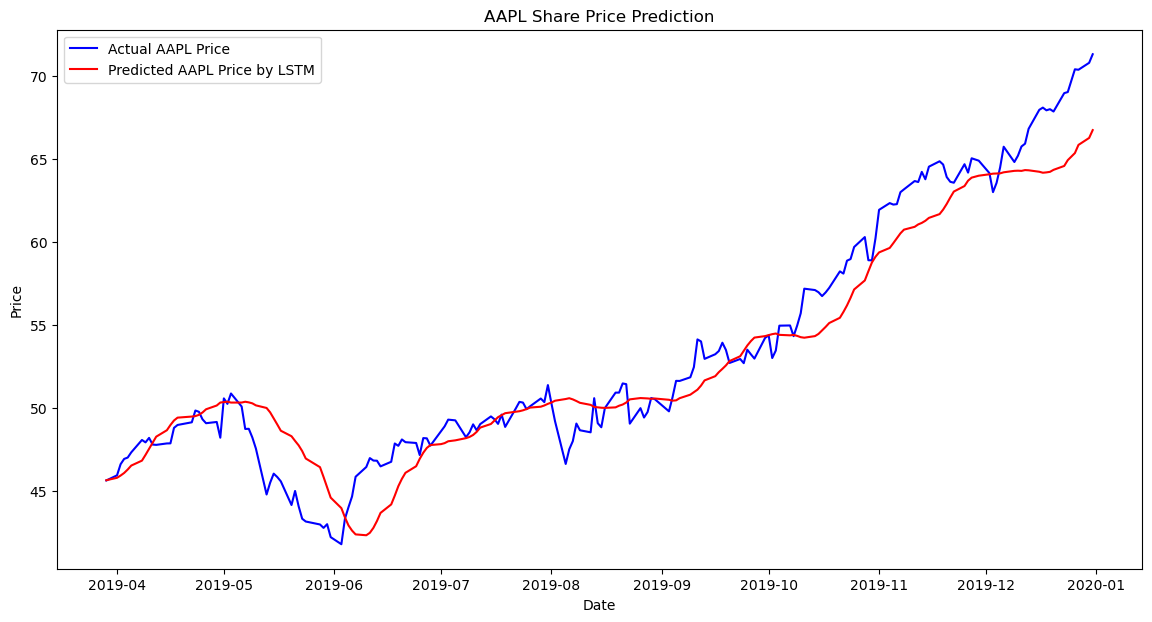

In [172]:
# change this to AMZN or GOOG
company = 'AAPL'
# change this to 'amzn_gpt.csv' or 'goog_gpt.csv'
data_gpt = pd.read_csv('aapl_gpt.csv')
data_gpt['Date'] = pd.to_datetime(data_gpt['Date'])

# Define training and test periods
train_end = dt.datetime(2018, 12, 31)
test_start = dt.datetime(2019, 1, 1)
test_end = dt.datetime(2020, 1, 1)

# Split the data
train_data = data_gpt[data_gpt['Date'] <= train_end]
test_data = data_gpt[(data_gpt['Date'] >= test_start) & (data_gpt['Date'] <= test_end)]

# Prepare the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
# change features, remove GPT_score if needed
features = ['Adj Close','GPT_score']
aapl_gpt2 = train_data.copy()
scaler2.fit(aapl_gpt2[features].values)
scaled_data = scaler.fit_transform(train_data[features].values)

# Set the number of prediction days
prediction_days = 60

# Prepare training sequences
x_train = []
y_train = []
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, :])
    y_train.append(scaled_data[x, 0])  # Predicting the 'Adj Close' value

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))
y_train = np.reshape(y_train, (y_train.shape[0], 1))


# Define LSTM model
def LSTM_model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, activation="tanh", input_shape=(x_train.shape[1], len(features))))
    # set dropout rate
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation="tanh", return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # set epochs and batch size
    model.fit(x_train, y_train, epochs=25, batch_size=64)
    return model    


# Train the model
model = LSTM_model(x_train, y_train)

# Prepare the test data
actual_prices = test_data['Adj Close'].values[prediction_days:]

scaler_inputs = scaler.transform(test_data[features].values)
x_test = []
for x in range(prediction_days, len(scaler_inputs)):
    x_test.append(scaler_inputs[x-prediction_days:x, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Use the trained model to predict
predicted_prices_LSTM = model.predict(x_test)

# Prepare for inverse transform
predicted_prices_combined = np.zeros((predicted_prices_LSTM.shape[0], len(features)))
predicted_prices_combined[:, 0] = predicted_prices_LSTM[:, 0]

# Inverse transform to get the actual predicted prices
predicted_prices_LSTM = scaler2.inverse_transform(predicted_prices_combined)[:, 0]

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_prices_LSTM, squared=False)
print(f"RMSE: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_prices_LSTM)
print(f"MAPE: {mape}")


# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'].values[prediction_days:], actual_prices, color='blue', label=f"Actual {company} Price")
plt.plot(test_data['Date'].values[prediction_days:], predicted_prices_LSTM, color='red', label=f"Predicted {company} Price by LSTM")
plt.title(f"{company} Share Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [173]:
print("X train")
print(x_train)
print("Y train")
print(y_train)

X train
[[[0.10571949 0.36111111]
  [0.08585247 0.38888889]
  [0.08591707 0.16666667]
  ...
  [0.19864602 0.66666667]
  [0.21885039 0.66666667]
  [0.20628707 0.94444444]]

 [[0.08585247 0.38888889]
  [0.08591707 0.16666667]
  [0.09552795 0.83333333]
  ...
  [0.21885039 0.66666667]
  [0.20628707 0.94444444]
  [0.20512174 0.38888889]]

 [[0.08591707 0.16666667]
  [0.09552795 0.83333333]
  [0.1222324  0.77777778]
  ...
  [0.20628707 0.94444444]
  [0.20512174 0.38888889]
  [0.21205088 0.63888889]]

 ...

 [[0.96684806 0.63888889]
  [0.98077041 0.5       ]
  [1.         0.66666667]
  ...
  [0.44300471 0.55555556]
  [0.41603127 0.33333333]
  [0.48754626 0.72222222]]

 [[0.98077041 0.5       ]
  [1.         0.66666667]
  [0.97187925 0.27777778]
  ...
  [0.41603127 0.33333333]
  [0.48754626 0.72222222]
  [0.48049144 0.38888889]]

 [[1.         0.66666667]
  [0.97187925 0.27777778]
  [0.94637756 0.33333333]
  ...
  [0.48754626 0.72222222]
  [0.48049144 0.38888889]
  [0.48104464 0.61111111]]]
Y 

In [174]:
print("X test")
print(x_test)
print("Y test")
print(actual_prices)

X test
[[[0.49273334 0.13888889]
  [0.38393921 0.38888889]
  [0.42592156 0.27777778]
  ...
  [0.69794906 0.38888889]
  [0.70961847 0.81111111]
  [0.71135503 0.77777778]]

 [[0.38393921 0.38888889]
  [0.42592156 0.27777778]
  [0.42363908 0.60833333]
  ...
  [0.70961847 0.81111111]
  [0.71135503 0.77777778]
  [0.71989858 0.27777778]]

 [[0.42592156 0.27777778]
  [0.42363908 0.60833333]
  [0.4431434  0.22222222]
  ...
  [0.71135503 0.77777778]
  [0.71989858 0.27777778]
  [0.72885886 0.61111111]]

 ...

 [[0.93306023 0.63888889]
  [0.94607891 0.22222222]
  [0.98940403 0.83333333]
  ...
  [1.39425957 0.88888889]
  [1.3961551  0.83333333]
  [1.43574979 0.83333333]]

 [[0.94607891 0.22222222]
  [0.98940403 0.83333333]
  [0.98975406 0.72222222]
  ...
  [1.3961551  0.83333333]
  [1.43574979 0.83333333]
  [1.43497676 0.38888889]]

 [[0.98940403 0.83333333]
  [0.98975406 0.72222222]
  [0.97113621 0.16666667]
  ...
  [1.43574979 0.83333333]
  [1.43497676 0.38888889]
  [1.44705154 0.94444444]]]
Y t

In [176]:
from scipy.stats import ttest_rel
# Note down the RMSE with and without sentiment analysis
print("rmse_without_sentiment = [2.85, 2.68, 3.14, 2.25, 3.57]")
print("rmse_with_sentiment = [1.68, 1.92, 2.73, 2.21, 2.58]")
# Example performance metrics
rmse_without_sentiment = [2.85, 2.68, 3.14, 2.25, 3.57]  # RMSE values for baseline model
rmse_with_sentiment = [1.68, 1.92, 2.73, 2.21, 2.58]     # RMSE values for model with sentiment analysis

# Perform paired t-test
t_stat, p_value = ttest_rel(rmse_without_sentiment, rmse_with_sentiment)
print(f"Paired t-test: t-statistic = {t_stat}, p-value = {p_value}")

if p_value < 0.05:
    print("The difference in performance is statistically significant.")
else:
    print("The difference in performance is not statistically significant.")

rmse_without_sentiment = [2.85, 2.68, 3.14, 2.25, 3.57]
rmse_with_sentiment = [1.68, 1.92, 2.73, 2.21, 2.58]
Paired t-test: t-statistic = 3.318707507734455, p-value = 0.029414021691847092
The difference in performance is statistically significant.
